In [1]:
from numba import njit, prange, set_num_threads
import numpy as np

@njit()
def F(a,b,c,work):
    s= 0.
    for w in range(work):
        for m in range(b.shape[0]):
            s += a + b[m]*c[m]  + float(w)
    return s

@njit()
def K1(a, b,c, c_index, o,  id, work):
    #process in blocks on threads
    s= 0.
    for n in id:
        o[n] = F(a[n], b[n, :], c[c_index[n], :],work)  # random row acess to C rows
        s += o[n]
    return s

@njit(parallel=True)
def K2(a, b, c, c_index, o, id,work):
    s= 0.
    for i in prange(id.size):
        n = id[i]
        o[n] = F(a[n], b[n, :], c[c_index[n], :],work)  # random row acess to C rows
        s += o[n]
    return s

# compare answers
N=100
M=10
A = np.random.rand(N)
B = np.random.rand(N,M)
C = np.random.rand(N,M)
O = np.zeros((N,),dtype=np.float64)
mask =(np.random.rand(N) > .5).astype(bool)
id = np.sort(np.flatnonzero(mask)).astype(np.int32)

# random access to c rows
c_index= np.random.randint(0,high=N,size=N)
w= 2
print('check',K1(A, B,C, c_index,O, id,w),K2(A, B, C, c_index, O, id,w))

check 1334.4738846158043 1334.4738846158043


In [2]:
import timeit
from time import perf_counter
import psutil

n_cores = psutil.cpu_count(logical=True)
t0 = perf_counter()



threads = np.arange(1,n_cores)
particles=  np.asarray([10**5,5*10**5, 10**6,5*10**6])
work  = np.asarray([1,10,100])
number = 10

d0 = np.zeros((work.size,particles.size ))
d = np.zeros((work.size,particles.size,threads.size  ))
for n_work, w in enumerate(work):
    for n_particles, N in enumerate(particles):

        A = np.random.rand(N)
        B = np.random.rand(N, M)
        C = np.random.rand(N, M)
        O = np.zeros((N,), dtype=np.float64)
        c_index = np.random.randint(0, high=N, size=N)

        mask = (np.random.rand(N) > .8).astype(bool)
        id = np.sort(np.flatnonzero(mask)).astype(np.int32)

       

        # reference case 
        K1(A, B, C, c_index, O, id[:2],w) # recompile before timing 
        
        t1= np.asarray(timeit.repeat(lambda  : K1(A, B,C,c_index, O, id,w),  number =number))
        d0[n_work,n_particles] =t1.mean()
        print('ref case ',t1.mean(),t1.std())

        for n_threads in range(threads.size):
            set_num_threads(threads[n_threads])
            
            K2(A, B, C, c_index, O, id[:2],w) # recompile before timing 

            t2 = np.asarray(timeit.repeat(lambda: K2(A, B,C, c_index, O, id,w), number=number))
            d[n_work,n_particles,n_threads] =t2.mean()
            print('work',w ,'N=', N, 'K2 threads=',threads[n_threads],'time=', t2.mean(),t2.std())


print('test time',perf_counter()-t0)

ref case  0.0042727199999973205 0.0004046277222325201
work 1 N= 100000 K2 threads= 1 time= 0.004195440000000872 0.0009858238191479583
work 1 N= 100000 K2 threads= 2 time= 0.0019585200000051374 0.00013855376429495951
work 1 N= 100000 K2 threads= 3 time= 0.0013043799999934436 9.79299423054526e-05
work 1 N= 100000 K2 threads= 4 time= 0.0009336199999978589 0.00013410234002338264
work 1 N= 100000 K2 threads= 5 time= 0.0007596200000023146 8.654135196777027e-05
work 1 N= 100000 K2 threads= 6 time= 0.0006367999999980611 0.00011408887763207489
work 1 N= 100000 K2 threads= 7 time= 0.0005607999999995173 7.025775402375582e-05
work 1 N= 100000 K2 threads= 8 time= 0.0005122999999969124 8.698535508755804e-05
work 1 N= 100000 K2 threads= 9 time= 0.00047005999999782944 6.22151621391875e-05
work 1 N= 100000 K2 threads= 10 time= 0.000407460000002402 4.45669204665778e-05
work 1 N= 100000 K2 threads= 11 time= 0.0003969200000000228 5.9461126796334166e-05
work 1 N= 100000 K2 threads= 12 time= 0.0003426999999

KeyboardInterrupt: 

# Plot scaling with thread count

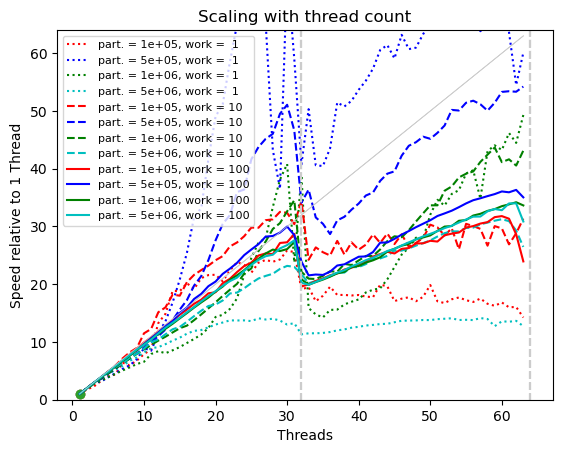

In [ ]:
from matplotlib import pyplot as plt
lt=['dotted','dashed','solid']

import psutil
n_cores = psutil.cpu_count(logical=True)
n_physical_cores = psutil.cpu_count(logical=False)

colours= [u'r', u'b', u'g', u'c', u'm', u'y', u'k']

for n_work in range(d.shape[0]):
    for n_part in range(d.shape[1]):
        dd = d[n_work,n_part,:]
        plt.plot(threads,dd[0]/dd, c=colours[n_part],
                 label=f'part. = {particles[n_part]:1.0e}, work = {work[n_work]:2d}',
                 linestyle =lt[n_work] )

    plt.plot(threads,threads,c=[.8,.8,.8],lw=.5,linestyle ='solid')

    ax= plt.gca()
    plt.plot(n_physical_cores*np.ones((2,)),ax.get_xlim(),c=[.8, .8,.8],linestyle='dashed')
    plt.plot(n_cores*np.ones((2,)),ax.get_xlim(),c=[.8, .8,.8],linestyle='dashed')
    
    plt.scatter(1,dd[0]/d0[n_work,n_part])
    plt.xlabel('Threads')
    plt.ylabel('Speed relative to 1 Thread')
    plt.legend(prop={'size': 8})
    plt.title('Scaling with thread count')
    ax.set_ylim([0,n_cores])
plt.show()

# Scaling with particle numbers

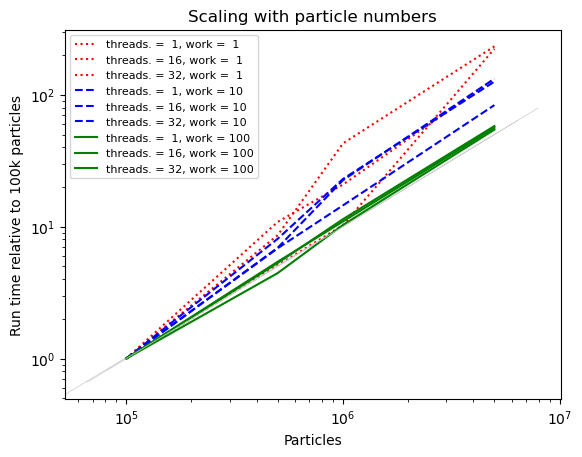

In [ ]:
show_threads =np.asarray([1,int(n_physical_cores/2), int(n_physical_cores)])

lt=['dotted','dashed','solid']
for n_work in range(d.shape[0]):
    for n_threads, show_thread in  enumerate(show_threads):
        dd = d[n_work,:,threads==show_thread].squeeze()
        plt.plot(particles,dd/dd[0], c=colours[n_work],
                 label=f'threads. = {show_thread:2d}, work = {work[n_work]:2d}',
                 linestyle =lt[n_work] )

    
    ax= plt.gca()

    xl = ax.get_xlim()
    plt.plot(xl,(xl-particles[0])/particles[0]+1,c=[.8,.8,.8],lw=.5,linestyle ='solid')
    plt.xlabel('Particles')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylabel('Run time relative to 100k particles')
    plt.legend(prop={'size': 8})
    plt.title('Scaling with particle numbers')

plt.show()

# Scaling with work load

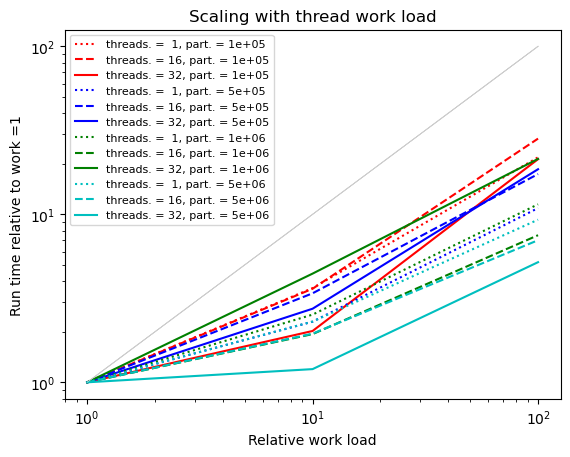

In [ ]:
show_threads =np.asarray([1, int(n_physical_cores/2), int(n_physical_cores)])
lt=['dotted', 'dashed', 'solid']

for n_part in range(particles.size):  
    for n_threads, show_thread in  enumerate(show_threads):
   
        dd = d[:,n_part,threads==show_thread].squeeze()
        plt.plot(work,dd/dd[0], c=colours[n_part],
                    label=f'threads. = {show_thread:2d}, part. = {particles[n_part]:2.0e}',
                    linestyle =lt[n_threads] )

    
    ax= plt.gca()
   
     
    #plt.scatter(1,dd[0]/d0[n_work,n_part])
    plt.xlabel('Relative work load')
    plt.plot(work,work,c=[.8,.8,.8],lw=.5,linestyle ='solid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylabel('Run time relative to work =1')
    plt.legend(prop={'size': 8})
    plt.title('Scaling with thread work load')

plt.show()